<a href="https://githubtocolab.com/fuszti/advent_of_code_2022/blob/main/day_07/AoC_2022_Day_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

<details>
<summary>What is this notebook?</summary>
The [Advent of Code](https://adventofcode.com/2022) is an advent calendar with programming tasks. You have to solve 2 algorithmic problems on each day. I challenge myself to solve them by data scientist tools. So you will see pandas, numpy, torch or datatable tricks here. The tasks are not data scientist tasks, so you can find easier or faster solutions. Perhaps you sometimes find my solutions too artificial. But I try to use the data scientist tool as meaningful way as I can.

In [my repository](https://github.com/fuszti/advent_of_code_2022) you find the input.txt file for each day. You can upload that to here, so you can run the code on big input.
</details>

In [2]:
#@title Creating example small input file { display-mode: "form" }
small_input_text = \
"""$ cd /
$ ls
dir a
14848514 b.txt
8504156 c.dat
dir d
$ cd a
$ ls
dir e
29116 f
2557 g
62596 h.lst
$ cd e
$ ls
584 i
$ cd ..
$ cd ..
$ cd d
$ ls
4060174 j
8033020 d.log
5626152 d.ext
7214296 k"""
with open("small_input.txt", "w") as small_file:
    small_file.write(small_input_text)

# Task 1
Source: https://adventofcode.com/2022/day/7
<details>
  <summary>Show me the description of the task 1</summary>
--- Day 7: No Space Left On Device ---
You can hear birds chirping and raindrops hitting leaves as the expedition proceeds. Occasionally, you can even hear much louder sounds in the distance; how big do the animals get out here, anyway?

The device the Elves gave you has problems with more than just its communication system. You try to run a system update:

$ system-update --please --pretty-please-with-sugar-on-top
Error: No space left on device
Perhaps you can delete some files to make space for the update?

You browse around the filesystem to assess the situation and save the resulting terminal output (your puzzle input). For example:

$ cd /
$ ls
dir a
14848514 b.txt
8504156 c.dat
dir d
$ cd a
$ ls
dir e
29116 f
2557 g
62596 h.lst
$ cd e
$ ls
584 i
$ cd ..
$ cd ..
$ cd d
$ ls
4060174 j
8033020 d.log
5626152 d.ext
7214296 k
The filesystem consists of a tree of files (plain data) and directories (which can contain other directories or files). The outermost directory is called /. You can navigate around the filesystem, moving into or out of directories and listing the contents of the directory you're currently in.

Within the terminal output, lines that begin with $ are commands you executed, very much like some modern computers:

cd means change directory. This changes which directory is the current directory, but the specific result depends on the argument:
cd x moves in one level: it looks in the current directory for the directory named x and makes it the current directory.
cd .. moves out one level: it finds the directory that contains the current directory, then makes that directory the current directory.
cd / switches the current directory to the outermost directory, /.
ls means list. It prints out all of the files and directories immediately contained by the current directory:
123 abc means that the current directory contains a file named abc with size 123.
dir xyz means that the current directory contains a directory named xyz.
Given the commands and output in the example above, you can determine that the filesystem looks visually like this:

- / (dir)
  - a (dir)
    - e (dir)
      - i (file, size=584)
    - f (file, size=29116)
    - g (file, size=2557)
    - h.lst (file, size=62596)
  - b.txt (file, size=14848514)
  - c.dat (file, size=8504156)
  - d (dir)
    - j (file, size=4060174)
    - d.log (file, size=8033020)
    - d.ext (file, size=5626152)
    - k (file, size=7214296)
Here, there are four directories: / (the outermost directory), a and d (which are in /), and e (which is in a). These directories also contain files of various sizes.

Since the disk is full, your first step should probably be to find directories that are good candidates for deletion. To do this, you need to determine the total size of each directory. The total size of a directory is the sum of the sizes of the files it contains, directly or indirectly. (Directories themselves do not count as having any intrinsic size.)

The total sizes of the directories above can be found as follows:

The total size of directory e is 584 because it contains a single file i of size 584 and no other directories.
The directory a has total size 94853 because it contains files f (size 29116), g (size 2557), and h.lst (size 62596), plus file i indirectly (a contains e which contains i).
Directory d has total size 24933642.
As the outermost directory, / contains every file. Its total size is 48381165, the sum of the size of every file.
To begin, find all of the directories with a total size of at most 100000, then calculate the sum of their total sizes. In the example above, these directories are a and e; the sum of their total sizes is 95437 (94853 + 584). (As in this example, this process can count files more than once!)

Find all of the directories with a total size of at most 100000. What is the sum of the total sizes of those directories?
</details>

In [8]:
from dataclasses import dataclass
from matplotlib import pyplot as plt
from typing import List, Dict

In [17]:
THRESHOLD = 100000
@dataclass
class File:
    size: int

@dataclass
class Folder:
    parent: 'Folder'
    folders: Dict[str, 'Folder']
    files: List[File]
    size: int = -1

    def is_size_calculated(self):
        return self.size > 0

def default_size_plotter(folders: List[Folder], threshold=100000):
    fig, ax = plt.subplots()
    for i, folder in enumerate(folders):
        c = "r" if folder.size <= threshold else "b"
        ax.bar(i, folder.size, color=c)
    ax.legend()

def solve_task_1(input_file_name, size_plot=default_size_plotter):
    root_folder, folders = read_prompt(input_file_name)
    calculate_folder_sizes(root_folder)
    size_plot(folders, THRESHOLD)
    print(sum([f.size for f in folders if f.size <=THRESHOLD]))

def read_prompt(input_file_name):
    root = Folder(None, {"/": Folder(None, {}, [])}, [])
    folders = []
    current_folder = root
    with open(input_file_name, "r") as input_file:
        for line in input_file:
            line = line.strip()
            parts = line.split()
            if _is_cd_command(parts):
                if parts[2] == "..":
                    current_folder = current_folder.parent
                else:
                    current_folder = current_folder.folders[parts[2]]
            elif _is_dir_name(parts):
                folders.append(Folder(current_folder, {}, []))
                current_folder.folders[parts[1]] = folders[-1]
            elif _is_file(parts):
                current_folder.files.append(File(int(parts[0])))
            else:
                continue
    return root, folders

def calculate_folder_sizes(folder):
    folder.size = 0
    for current_file in folder.files:
        folder.size += current_file.size
    for _, current_folder in folder.folders.items():
        if not current_folder.is_size_calculated():
            calculate_folder_sizes(current_folder)
        folder.size += current_folder.size

def _is_cd_command(parts):
    return parts[1] == "cd"

def _is_dir_name(parts):
    return parts[0] == "dir"

def _is_file(parts):
    return len(parts) == 2 and parts[0] != "$" and \
        parts[0] != "dir"

1206825


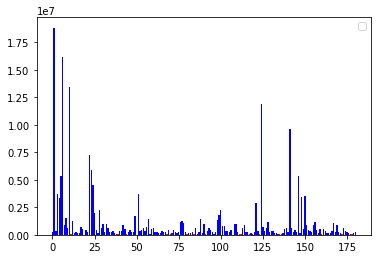

In [19]:
input_file_name = "small_input.txt"
solve_task_1(input_file_name)

## Key tricks
Eeeeh, coloring bars. But on side of classic algorithms it is a tree building.

# Task 2

Source: https://adventofcode.com/2022/day/7
<details>
  <summary>Show me the description of the task 2</summary>
  
--- Part Two ---
Now, you're ready to choose a directory to delete.

The total disk space available to the filesystem is 70000000. To run the update, you need unused space of at least 30000000. You need to find a directory you can delete that will free up enough space to run the update.

In the example above, the total size of the outermost directory (and thus the total amount of used space) is 48381165; this means that the size of the unused space must currently be 21618835, which isn't quite the 30000000 required by the update. Therefore, the update still requires a directory with total size of at least 8381165 to be deleted before it can run.

To achieve this, you have the following options:

Delete directory e, which would increase unused space by 584.
Delete directory a, which would increase unused space by 94853.
Delete directory d, which would increase unused space by 24933642.
Delete directory /, which would increase unused space by 48381165.
Directories e and a are both too small; deleting them would not free up enough space. However, directories d and / are both big enough! Between these, choose the smallest: d, increasing unused space by 24933642.

Find the smallest directory that, if deleted, would free up enough space on the filesystem to run the update. What is the total size of that directory?
</details>

In [20]:
FILESYSTEM_SIZE = 70000000
REQUIRED_SPACE = 30000000
def solve_task_2(input_file_name):
    root_folder, folders = read_prompt(input_file_name)
    calculate_folder_sizes(root_folder)
    deletable_folders_size = [f.size for f in folders \
                         if FILESYSTEM_SIZE - root_folder.size + f.size \
                         >= REQUIRED_SPACE]
    print(min(deletable_folders_size))

In [22]:
input_file_name = "small_input.txt"
solve_task_2(input_file_name)

9608311


## Key tricks
Nothing